In [88]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit
from numba.types import pyobject
import numba
import time

## Defining the class

In [89]:
@njit(parallel=True)
def force(q):
    F = q - q**3
    return F

@njit(parallel=True)
def A_step( qp , h , factor=1):
    q,p = qp

    q = q + h*p*factor

    return [q,p]

@njit(parallel=True)
def B_step( qp , h, factor=1):
    q,p = qp

    F = q - q**3

    p = p + h*F*factor

    return [q,p]


@njit()
def O_step( qp , h,gamma, factor=1):
    q,p = qp

    alpha = np.exp(-h*gamma)

    R = np.random.randn( q.size ).reshape( q.shape)
    p = np.exp(- gamma*h *factor)*p+ np.sqrt(1-np.exp(-gamma*h))*R

    return [q,p]

@njit()
def obabo_step(q,p,h,gamma,beta):
    qp = [q,p]  #this just translates the separate q and p vectors
                #into a single vector composed from the pair.
    qp = O_step( qp, h, gamma, 0.5)
    qp = B_step( qp, h,0.5)
    qp = A_step(qp , h )
    qp = B_step( qp, h,0.5)
    qp = O_step( qp, h, gamma,  0.5)

    q,p = qp
    return q , p


In [90]:
 q_traj= np.array([[]])
numba.typeof(q_traj)

array(float64, 2d, C)

# Defining a class for the integrators

In [91]:
@njit()
def run_simulation(Nsteps, h, gamma,q_init= np.array([]),p_init= np.array([])):
    beta = 1
    q_traj = [q_init]



    q = np.copy(q_init)
    p = np.copy(p_init)
    t = 0

    for n in range(Nsteps):
        q,p = obabo_step(q, p, h, gamma, beta)
        t = t + h

        q_traj += [q]

    #q_traj = np.array(q_traj)
    #p_traj = np.array(p_traj)
    #t_traj = np.array(t_traj)

    return q_traj

In [92]:
@njit()
def simulate_trajectories(n_steps, stepsize, gammas, q_init = np.array([]), p_init = np.array([])):
    trajectories = []
    for gamma in gammas:
        q_traj = run_simulation( n_steps , stepsize, gamma,q_init, p_init)
        trajectories.append(q_traj)
    return gammas, trajectories

In [93]:
@njit
def numbadiff(x):
    return x[1:] - x[:-1]

In [102]:
class Scheme:
    def __init__(self, step_funtion, force, potential):
        self.step_function = step_funtion
        self.force = force
        self.potential = potential
    def convergence_graph(self, n_steps, stepsize, sims,gammas, q_init = None, p_init = None):
        if q_init is None:
            q_init = np.zeros(sims)
        if p_init is None:
            p_init = np.zeros(sims)
        gammas, trajectories = simulate_trajectories(n_steps, stepsize, gammas, q_init, p_init)
        for i in range(len(trajectories)):
            q_traj= trajectories[i]
            #print(np.shape(q_traj))
            q_hists = [np.histogram(q,bins=50,range=[-3,3], density=True)[0] for q in q_traj]
            q_diff = np.diff(q_hists)
            q_diffs = np.array([np.linalg.norm(diff) for diff in q_diff])
            plt.plot(q_diffs, alpha = 0.3, label=f'Friction = {gammas[i]}')
            plt.xlabel('$q$')
            plt.ylabel('2-norm of difference')
            #plt.yscale('log')

        plt.title("Convergence of $q$ for different values of friction")
        plt.legend()

    def friction_graph(self, n_steps, stepsize, sims,gammas, q_init = None, p_init = None):
        if q_init is None:
            q_init = np.zeros(sims)
        if p_init is None:
            p_init = np.zeros(sims)
        gammas, trajectories = simulate_trajectories(n_steps, stepsize, gammas, q_init, p_init)
        fig = plt.figure(figsize=[10,7])
        for i in range(len(trajectories)):
            q_traj= trajectories[i]
            histogram,bins = np.histogram(q_traj[-1],bins=50,range=[-3,3], density=True)
            midx = (bins[0:-1]+bins[1:])/2
            plt.plot(midx,histogram,label=f'Friction = {gammas[i]}')
            plt.xlabel('$q$')
            plt.ylabel('Density')


        plt.title("Distribution of $q$ for different values of friction")
        rho = np.exp( -self.potential(midx))
        rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) )
        plt.plot(midx,rho,'--',label='Truth')
        plt.legend()

    def cum_mean(traj_mean, cut_out):
        traj_2 = traj_mean[cut_out:]
        return np.cumsum(traj_2)/ np.arange(1, len(traj_2)+1)

    def expectation_graph(self, function, n_steps, stepsize, sims,gammas, q_init, p_init):
        if q_init is None:
            q_init = np.zeros(sims)
        if p_init is None:
            p_init = np.zeros(sims)


        fig = plt.figure(figsize=[10,7])
        gammas, trajectories = simulate_trajectories(n_steps, stepsize, gammas, q_init, p_init)

        for i in range(len(trajectories)):
            q_traj = np.array(trajectories[i])
            q_traj = function(q_traj)
            gamma = gammas[i]
            expectation = Scheme.cum_mean(np.mean(q_traj, axis = 1), 5000)
            plt.plot(expectation, label = f"Gamma = {gamma}")
        plt.ylabel('$Expectation$')
        plt.xlabel('Number of Iterations')


        plt.title("Expectation Graph")
        plt.legend()
        #plt.show()

In [103]:
@njit(parallel=True)
def U(x):
    return - x**2/2 + x**4/4

# Graphing the results of the simulation

In [104]:
OBABO = Scheme(obabo_step, force, U)

In [105]:
gammas = np.array([float(10**(2*p)) for p in range(-3,3)])

Time Elapsed: 5.468163251876831


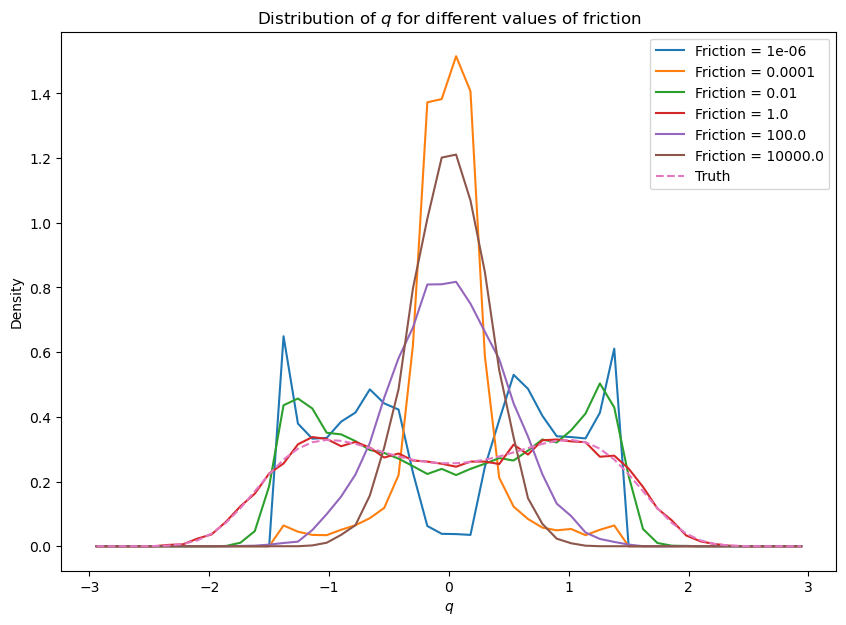

In [106]:
# running 1000 simulations, each taking 100000 steps of size 0.01
start_time =time.time()
OBABO.friction_graph(1000, 0.01, 10000, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 2.746222734451294


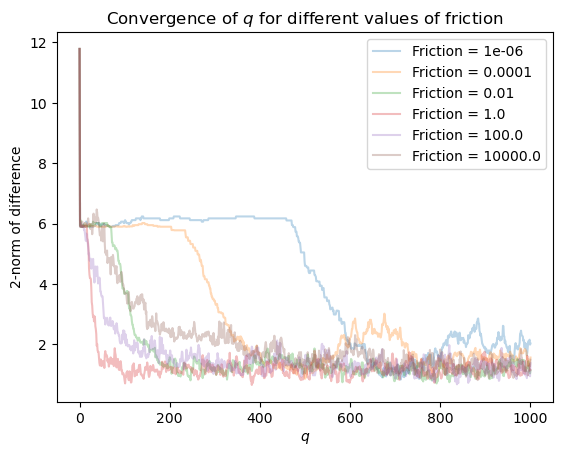

In [107]:
start_time =time.time()
OBABO.convergence_graph(1000, 0.01, 100, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 19.63957190513611


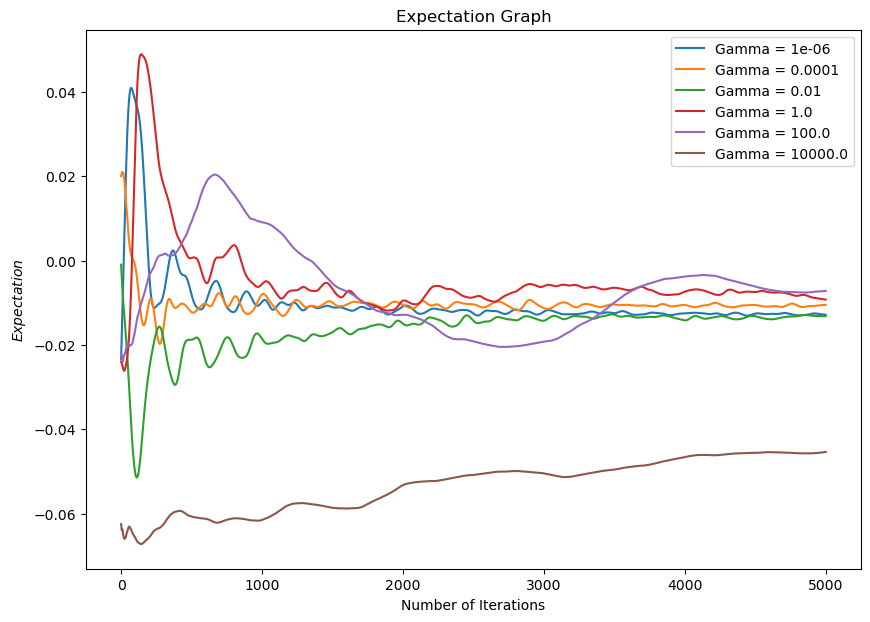

In [108]:
start_time =time.time()
OBABO.expectation_graph(U,10000, 0.01, 100, gammas, q_init = np.random.normal(size =100), p_init = np.random.normal(size = 100))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

In [117]:
@jit(nopython=True)
def square(x):
    return x**2

@jit(nopython=True)
def nothing(x):
    return x

Time Elapsed: 45.869734048843384


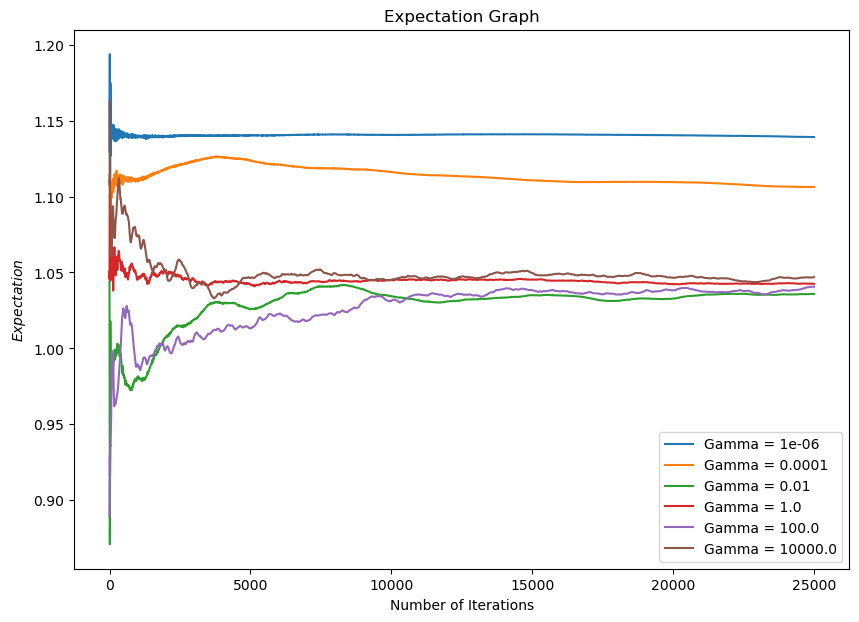

In [121]:
start_time =time.time()
OBABO.expectation_graph(square,30000, 0.1, 1000, gammas, q_init = np.random.normal(size =100), p_init =np.random.normal(size = 100))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 31.713119983673096


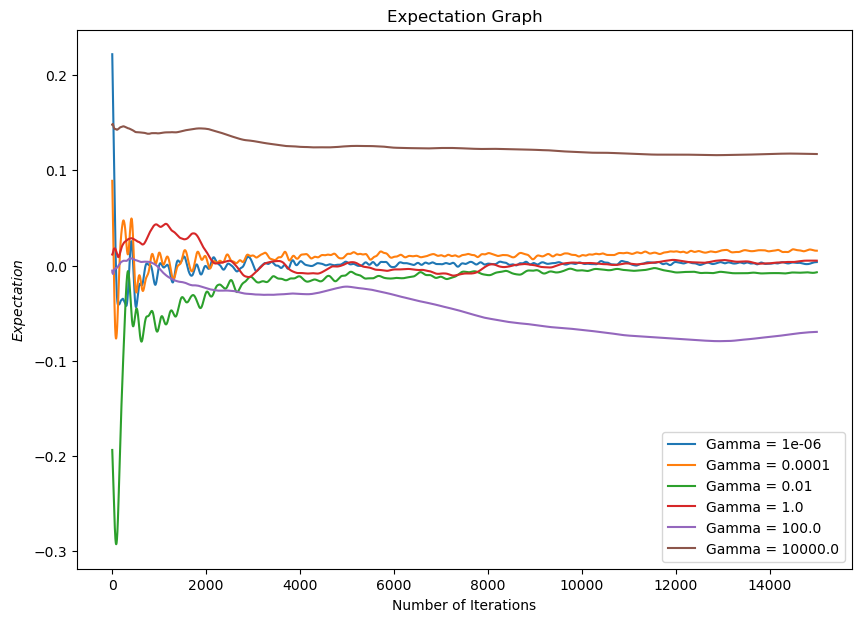

In [118]:
start_time =time.time()
OBABO.expectation_graph(nothing,20000, 0.01, 100, gammas, q_init = np.random.normal(size =100), p_init = np.random.normal(size = 100))
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

# A new potential
$U(x) = \log{( e^{2(x-1)^2} + e^{2(x+1)^2} + e^{-(x-3)^2} + e^{(x+3)^2})}$

In [31]:
@jit(nopython=True)
def potential(x):
    return -np.log( np.exp(-2*(x-1)**2) + np.exp(-2*(x+1)**2) + np.exp(-2*(x+3)**2) + np.exp(-2*(x-3)**2))

In [32]:
@jit(nopython=True)
def force_2(x):
    r = 4*(x-1)*np.exp(-2*(x-1)**2)  +4*(x+1)*np.exp(-2*(x+1)**2)  +4*(x+3)*np.exp(-2*(x+3)**2) +4*(x-3)*np.exp(-2*(x-3)**2)
    F = -r/( np.exp(-2*(x-1)**2) + np.exp(-2*(x+1)**2) + np.exp(-2*(x+3)**2) + np.exp(-2*(x-3)**2))
    return F

@jit(nopython=True)
def A_step_2( qp , h , factor=1):
    q,p = qp

    q = q + h*p*factor

    return [q,p]

@jit(nopython=True)
def B_step_2( qp , h, factor=1):
    q,p = qp

    F = force_2(q)

    p = p + h*F*factor

    return [q,p]


@jit(nopython=True)
def O_step_2( qp , h,gamma, factor=1):
    q,p = qp

    alpha = np.exp(-h*gamma)

    R = np.random.randn( q.size ).reshape( q.shape)
    p = np.exp(- gamma*h *factor)*p+ np.sqrt(1-np.exp(-gamma*h))*R

    return [q,p]

@jit(nopython=True)
def obabo_step_2(q,p,h,gamma,beta):
    qp = [q,p]  #this just translates the separate q and p vectors
                #into a single vector composed from the pair.
    qp = O_step_2( qp, h, gamma, 0.5)
    qp = B_step_2( qp, h,0.5)
    qp = A_step_2(qp , h )
    qp = B_step_2( qp, h,0.5)
    qp = O_step_2( qp, h, gamma,  0.5)

    q,p = qp
    return q , p

In [33]:
@jit(nopython=True)
def run_simulation(Nsteps, h, gamma,q_init= np.array([]),p_init= np.array([])):
    beta = 1
    q_traj = [q_init]


    q = np.copy(q_init)
    p = np.copy(p_init)
    t = 0

    for n in range(Nsteps):
        q,p = obabo_step_2(q, p, h, gamma, beta)
        t = t + h

        q_traj += [q]

    #q_traj = np.array(q_traj)
    #p_traj = np.array(p_traj)
    #t_traj = np.array(t_traj)

    return q_traj

In [63]:
@jit(nopython=True)
def simulate_trajectories(n_steps, stepsize, gammas, q_init=np.array([]), p_init= np.array([])):
    trajectories = []
    for gamma in gammas:
        q_traj = run_simulation( n_steps , stepsize, gamma,q_init, p_init)
        trajectories.append(q_traj)
    return gammas, trajectories

In [35]:
class Scheme:
    def __init__(self, step_funtion, force, potential):
        self.step_function = step_funtion
        self.force = force
        self.potential = potential
    def convergence_graph(self, n_steps, stepsize, sims,gammas, q_init = None, p_init = None):
        if q_init == None:
            q_init = np.zeros(sims)
        if p_init == None:
            p_init = np.zeros(sims)
        gammas, trajectories = simulate_trajectories(n_steps, stepsize, gammas, q_init, p_init)
        for i in range(len(trajectories)):
            q_traj= trajectories[i]
            #print(np.shape(q_traj))
            q_hists = [np.histogram(q,bins=50, density=True)[0] for q in q_traj]
            q_diff = np.diff(q_hists)
            q_diffs = np.array([np.linalg.norm(diff) for diff in q_diff])
            plt.plot(q_diffs, alpha = 0.3, label=f'Friction = {gammas[i]}')
            plt.xlabel('$q$')
            plt.ylabel('2-norm of difference')
            plt.yscale('log')

        plt.title("Convergence of $q$ for different values of friction")
        plt.legend()

    def friction_graph(self, n_steps, stepsize, sims,gammas, q_init = None, p_init = None):
        if q_init is None:
            q_init = np.zeros(sims)
        if p_init is None:
            p_init = np.zeros(sims)
        gammas, trajectories = simulate_trajectories(n_steps, stepsize, gammas, q_init, p_init)
        fig = plt.figure(figsize=[10,7])
        for i in range(len(trajectories)):
            q_traj= trajectories[i]
            histogram,bins = np.histogram(q_traj,range = [-5,5], bins=50, density=True)
            midx = (bins[0:-1]+bins[1:])/2
            plt.plot(midx,histogram,label=f'Friction = {gammas[i]}')
            plt.xlabel('$q$')
            plt.ylabel('Density')


        plt.title("Distribution of $q$ for different values of friction")
        rho = np.exp( -self.potential(midx))
        rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) )
        plt.plot(midx,rho,'--',label='Truth')
        plt.legend()

    def cum_mean(traj_mean, cut_out):
        traj_2 = traj_mean[cut_out:]
        return np.cumsum(traj_2)/ np.arange(1, len(traj_2)+1)

    def expectation_graph(self, function, n_steps, stepsize, sims,gammas, q_init = None, p_init = None):
        if q_init == None:
            q_init = np.zeros(sims)
        if p_init == None:
            p_init = np.zeros(sims)


        fig = plt.figure(figsize=[10,7])
        gammas, trajectories = simulate_trajectories(n_steps, stepsize, gammas, q_init, p_init)

        for i in range(len(trajectories)):
            q_traj = trajectories[i]
            gamma = gammas[i]
            expectation = Scheme.cum_mean(np.mean(q_traj, axis = 1), 5000)
            plt.plot(expectation, label = f"Gamma = {gamma}")
        plt.ylabel('$Expectation$')
        plt.xlabel('Number of Iterations')


        plt.title("Expectation Graph")
        plt.legend()
        #plt.show()

In [36]:
OBABO_2 = Scheme(obabo_step_2, force_2, potential)

Time Elapsed: 15.219593286514282


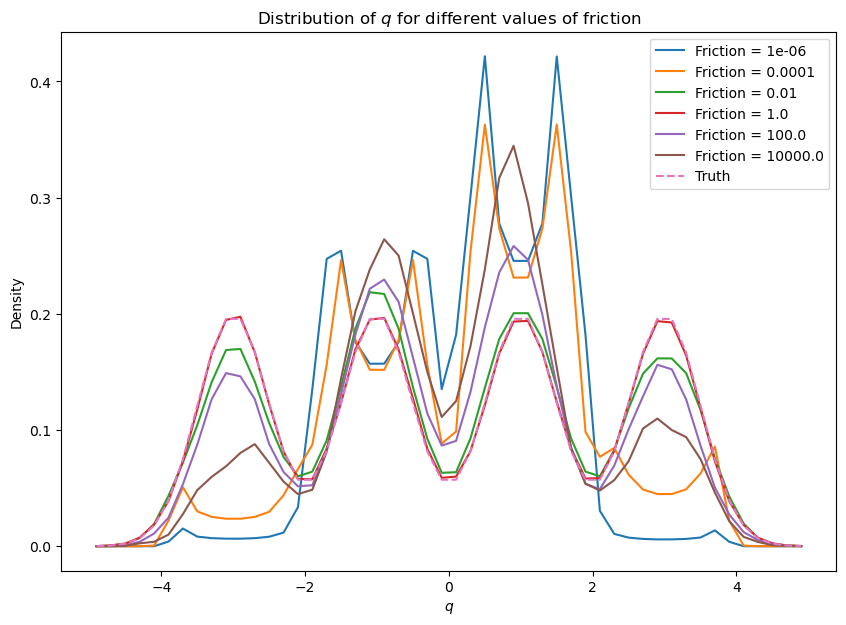

In [37]:
start_time =time.time()
OBABO_2.friction_graph(100000, 0.01, 100, gammas, q_init =np.random.normal())
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 91.73147344589233


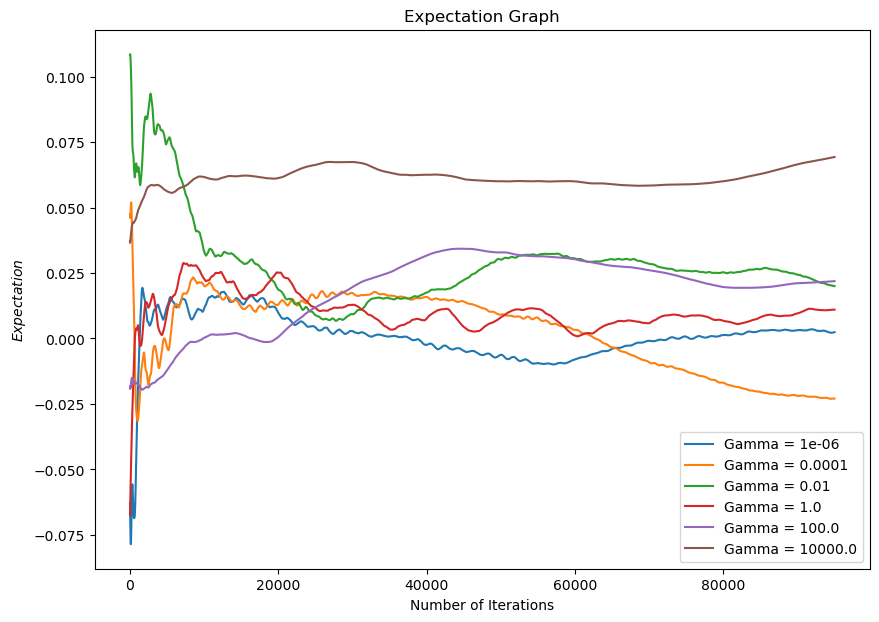

In [40]:
start_time =time.time()
OBABO_2.expectation_graph(potential,100000, 0.01, 1000, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")

Time Elapsed: 94.016348361969


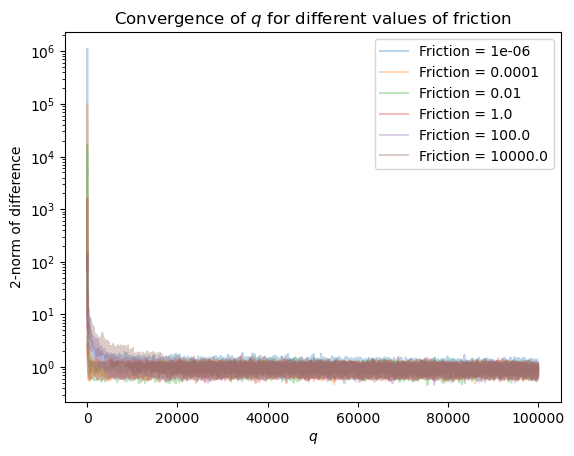

In [39]:
start_time =time.time()
OBABO_2.convergence_graph(100000, 0.01, 100, gammas)
end_time = time.time()
print(f"Time Elapsed: {end_time-start_time}")